In [1]:
import numpy as np
import os
import json
import tensorflow as tf
import random
import itertools
!pip install mediapipe
import mediapipe as mp
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 31.5 MB 143 kB/s 
Mounted at /content/drive


### Configure MediaPipe FaceMesh

In [2]:
mp_face_mesh = mp.solutions.face_mesh

### Grab data from training model

In [3]:
json_path = '/content/drive/Shareddrives/URSI 2022/Eye Tracking ML/json_pose/'
all_json_files = os.listdir(json_path)

json_data = {}
for filename in all_json_files:
  with open(json_path + filename, 'r') as file:
    s_data = json.load(file)
    json_data = {**json_data, **s_data}

### Set training data/training labels

In [4]:
left_eye_point = set(sum(mp_face_mesh.FACEMESH_LEFT_EYE, ()))
right_eye_point = set(sum(mp_face_mesh.FACEMESH_RIGHT_EYE, ()))
left_iris_point = set(sum(mp_face_mesh.FACEMESH_LEFT_IRIS, ()))
right_iris_point = set(sum(mp_face_mesh.FACEMESH_RIGHT_IRIS, ()))

face_oval_point = set(sum(mp_face_mesh.FACEMESH_FACE_OVAL, ()))

#keypoints = left_eye_point.union(right_eye_point).union(left_iris_point).union(right_iris_point)

keypoints = left_eye_point.union(right_eye_point).union(face_oval_point)

keypoints = sorted(list(keypoints))

In [5]:
added_points = [151, 9, 8, 168, 6, 197, 195, 5, 4]
for point in added_points:
    keypoints.append(point)

In [6]:
train_x = []

for subject in json_data:
  subject_data = json_data[subject];
  
  for video in subject_data:
    for all_features in video['features']:
      train_x.append([all_features[i] for i in keypoints])
        

### Set validation data/validation labels

In [7]:
#random.shuffle(train_x)

val_x = train_x[-6623:len(train_x)]
train_x = train_x[0:len(train_x) - 6623]

In [8]:
len(train_x)

40679

### No Data Augmentation VAE Setup/Performance

In [9]:
class Sampling(tf.keras.layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a mesh."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))

        kl_loss = 1/600 * -0.5 * tf.reduce_mean(z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1)
        self.add_loss(kl_loss)
        self.add_metric(kl_loss, name='kl_loss')

        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [10]:
latent_dim = 6
features = len(train_x[0])

vae_encoder_inputs = tf.keras.Input(shape=(features,3), name="vae_encoder_input")
vae_encoder_flatten = tf.keras.layers.Flatten(name="vae_flatten")(vae_encoder_inputs)
vae_encoder_dense_1 = tf.keras.layers.Dense(units=200, activation="relu", name="vae_dense_1")(vae_encoder_flatten)
vae_encoder_dense_2 = tf.keras.layers.Dense(units=100, activation="relu", name="vae_dense_2")(vae_encoder_dense_1)
vae_encoder_dense_3 = tf.keras.layers.Dense(units=50, activation="relu", name="vae_dense_3")(vae_encoder_dense_2)
z_mean = tf.keras.layers.Dense(units=latent_dim, name="z_mean")(vae_encoder_dense_3)
z_log_var = tf.keras.layers.Dense(units=latent_dim, name="z_log_var")(vae_encoder_dense_3)
vae_encoder = tf.keras.Model(inputs=vae_encoder_inputs, outputs=[z_mean, z_log_var])

vae_encoder.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 vae_encoder_input (InputLayer)  [(None, 77, 3)]     0           []                               
                                                                                                  
 vae_flatten (Flatten)          (None, 231)          0           ['vae_encoder_input[0][0]']      
                                                                                                  
 vae_dense_1 (Dense)            (None, 200)          46400       ['vae_flatten[0][0]']            
                                                                                                  
 vae_dense_2 (Dense)            (None, 100)          20100       ['vae_dense_1[0][0]']            
                                                                                              

In [11]:
z = Sampling(name="vae_sampling")([z_mean, z_log_var])

vae_decoder_dense_1 = tf.keras.layers.Dense(50, activation="relu", name="vae_decoder_dense_1")(z)
vae_decoder_dense_2 = tf.keras.layers.Dense(100, activation="relu", name="vae_decoder_dense_2")(vae_decoder_dense_1)
vae_decoder_dense_3 = tf.keras.layers.Dense(200, activation="relu", name="vae_decoder_dense_3")(vae_decoder_dense_2)
vae_decoder_dense_4 = tf.keras.layers.Dense(features*3, activation=None, name="vae_decoder_dense_4")(vae_decoder_dense_3)
vae_decoder_outputs = tf.keras.layers.Reshape((features,3), name="vae_decoder_reshape")(vae_decoder_dense_4)

vae_decoder = tf.keras.Model(inputs=z, outputs=vae_decoder_outputs)

vae_decoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 6)]               0         
                                                                 
 vae_decoder_dense_1 (Dense)  (None, 50)               350       
                                                                 
 vae_decoder_dense_2 (Dense)  (None, 100)              5100      
                                                                 
 vae_decoder_dense_3 (Dense)  (None, 200)              20200     
                                                                 
 vae_decoder_dense_4 (Dense)  (None, 231)              46431     
                                                                 
 vae_decoder_reshape (Reshap  (None, 77, 3)            0         
 e)                                                              
                                                           

In [12]:
vae = tf.keras.Model(inputs=vae_encoder_inputs, outputs=vae_decoder_outputs, name="VAE")

vae.summary()

Model: "VAE"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 vae_encoder_input (InputLayer)  [(None, 77, 3)]     0           []                               
                                                                                                  
 vae_flatten (Flatten)          (None, 231)          0           ['vae_encoder_input[0][0]']      
                                                                                                  
 vae_dense_1 (Dense)            (None, 200)          46400       ['vae_flatten[0][0]']            
                                                                                                  
 vae_dense_2 (Dense)            (None, 100)          20100       ['vae_dense_1[0][0]']            
                                                                                                

In [13]:
vae.compile(optimizer="adam", loss="mean_squared_error", metrics=["mean_squared_error"])

In [14]:
vae.fit(x=train_x, y=train_x, epochs=50)

Epoch 1/50
1272/1272 [==============================] - 7s 4ms/step - loss: 0.0077 - mean_squared_error: 0.0059 - kl_loss: 0.0019
Epoch 2/50
1272/1272 [==============================] - 5s 4ms/step - loss: 0.0038 - mean_squared_error: 0.0022 - kl_loss: 0.0016
Epoch 3/50
1272/1272 [==============================] - 5s 4ms/step - loss: 0.0033 - mean_squared_error: 0.0017 - kl_loss: 0.0016
Epoch 4/50
1272/1272 [==============================] - 6s 4ms/step - loss: 0.0031 - mean_squared_error: 0.0016 - kl_loss: 0.0015
Epoch 5/50
1272/1272 [==============================] - 6s 5ms/step - loss: 0.0030 - mean_squared_error: 0.0016 - kl_loss: 0.0014
Epoch 6/50
1272/1272 [==============================] - 6s 4ms/step - loss: 0.0030 - mean_squared_error: 0.0016 - kl_loss: 0.0014
Epoch 7/50
1272/1272 [==============================] - 6s 5ms/step - loss: 0.0029 - mean_squared_error: 0.0015 - kl_loss: 0.0014
Epoch 8/50
1272/1272 [==============================] - 6s 5ms/step - loss: 0.0029 - mean_

In [15]:
vae_encoder_fixed = tf.keras.Model(inputs=vae_encoder_inputs, outputs=z_mean)

vae_fixed = tf.keras.Sequential([vae_encoder_fixed, vae_decoder])

vae_fixed.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_2 (Functional)        (None, 6)                 71856     
                                                                 
 model_1 (Functional)        (None, 77, 3)             72081     
                                                                 
Total params: 143,937
Trainable params: 143,937
Non-trainable params: 0
_________________________________________________________________


In [16]:
validation_metrics = []
validation_metrics.append(vae.evaluate(val_x, val_x))

207/207 [==============================] - 1s 2ms/step - loss: 0.0027 - mean_squared_error: 0.0012 - kl_loss: 0.0015


In [ ]:
j = 0
reconstructions_arr = []
while j < (len(val_x)):
    example = np.array(val_x[j])
    reconstructions = vae_fixed.predict(np.reshape(example, (1, -1, 3)))
    reconstructions_arr.append(reconstructions[0])
    j += 1

i = 0
k = 0
x = []
y = []

while k < len(val_x[i]):
    x.append(val_x[i][k][0])
    y.append(val_x[i][k][1])
    k +=1

fig = plt.figure(figsize=(8,8))
ax = plt.axes(xlim=(0,1),ylim=(1,0))
scatter = ax.scatter(x, y, c='red')
scatter2 = ax.scatter(x, y, c='blue')

def update(n):
    x = []
    y = []
    k = 0
    global i
    coords = []
    coords2 = []

    while k < len(val_x[i]):
        x.append(val_x[i][k][0])
        y.append(val_x[i][k][1])
        coords.append([reconstructions_arr[i][k][0], reconstructions_arr[i][k][1]])
        coords2.append([val_x[i][k][0], val_x[i][k][1]])

        k +=1

    
    scatter.set_offsets(coords)
    scatter2.set_offsets(coords2)
    i += 1
    return scatter, scatter2

anim = FuncAnimation(fig, update, frames=(int((len(val_x)) / 4)), interval=60)
HTML(anim.to_html5_video())

Output hidden; open in https://colab.research.google.com to view.

### Explore latent representation of data

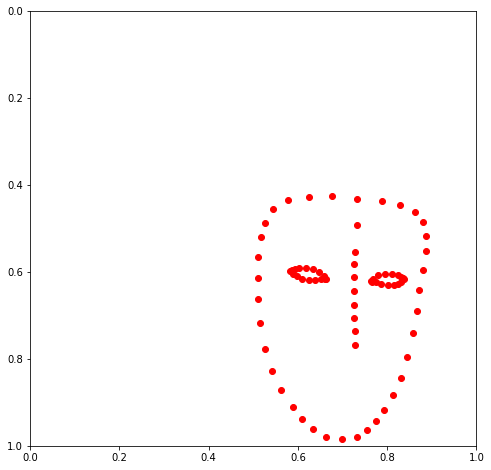

In [125]:
outputs = vae_decoder.predict([[1.3, 0.9, -0.5, 0.4, 0.8, 1.3]])
predictions = outputs[0]

x = []
y = []

for prediction in predictions:
    x.append(prediction[0])
    y.append(prediction[1])

fig = plt.figure(figsize=(8,8))
ax = plt.axes(xlim=(0,1),ylim=(1,0))
scatter = ax.scatter(x, y, c='red')

### Test against prolific dataset samples

In [ ]:
json_path = '/content/drive/Shareddrives/URSI 2022/Eye Tracking ML/prolific_eye_data_experiment/vae_test_json/'
all_json_files = os.listdir(json_path)

json_data = {}
for filename in all_json_files:
  with open(json_path + filename, 'r') as file:
    s_data = json.load(file)
    json_data = {**json_data, **s_data}

In [ ]:
left_eye_point = set(sum(mp_face_mesh.FACEMESH_LEFT_EYE, ()))
right_eye_point = set(sum(mp_face_mesh.FACEMESH_RIGHT_EYE, ()))
left_iris_point = set(sum(mp_face_mesh.FACEMESH_LEFT_IRIS, ()))
right_iris_point = set(sum(mp_face_mesh.FACEMESH_RIGHT_IRIS, ()))

face_oval_point = set(sum(mp_face_mesh.FACEMESH_FACE_OVAL, ()))

#keypoints = left_eye_point.union(right_eye_point).union(left_iris_point).union(right_iris_point)

keypoints = left_eye_point.union(right_eye_point).union(face_oval_point)

keypoints = sorted(list(keypoints))

In [ ]:
added_points = [151, 9, 8, 168, 6, 197, 195, 5, 4]
for point in added_points:
    keypoints.append(point)

In [ ]:
prolific_val_x = []

for subject in json_data:
  subject_data = json_data[subject];
  
  for video in subject_data:
    for all_features in video['features']:
      prolific_val_x.append([all_features[i] for i in keypoints])

In [ ]:
vae.evaluate(prolific_val_x, prolific_val_x)

14/14 [==============================] - 0s 3ms/step - loss: 0.0024 - mean_squared_error: 7.3902e-04 - kl_loss: 0.0016


[0.002370272297412157, 0.0007390248938463628, 0.0016234448412433267]

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py", line 196, in process
    func(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/matplotlib/animation.py", line 951, in _start
    self._init_draw()
  File "/usr/local/lib/python3.7/dist-packages/matplotlib/animation.py", line 1743, in _init_draw
    self._draw_frame(next(self.new_frame_seq()))
  File "/usr/local/lib/python3.7/dist-packages/matplotlib/animation.py", line 1766, in _draw_frame
    self._drawn_artists = self._func(framedata, *self._args)
  File "<ipython-input-72-f8739506fa61>", line 32, in update
    while k < len(prolific_val_x[i]):
IndexError: list index out of range


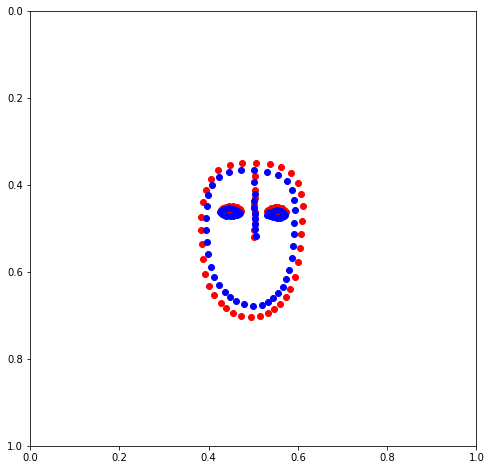

In [ ]:
j = 0
reconstructions_arr = []
while j < (len(prolific_val_x)):
    example = np.array(prolific_val_x[j])
    reconstructions = vae_fixed.predict(np.reshape(example, (1, -1, 3)))
    reconstructions_arr.append(reconstructions[0])
    j += 1

i = 0
k = 0
x = []
y = []

while k < len(prolific_val_x[i]):
    x.append(prolific_val_x[i][k][0])
    y.append(prolific_val_x[i][k][1])
    k +=1

fig = plt.figure(figsize=(8,8))
ax = plt.axes(xlim=(0,1),ylim=(1,0))
scatter = ax.scatter(x, y, c='red')
scatter2 = ax.scatter(x, y, c='blue')

def update(n):
    x = []
    y = []
    k = 0
    global i
    coords = []
    coords2 = []

    while k < len(prolific_val_x[i]):
        x.append(prolific_val_x[i][k][0])
        y.append(prolific_val_x[i][k][1])
        coords.append([reconstructions_arr[i][k][0], reconstructions_arr[i][k][1]])
        coords2.append([prolific_val_x[i][k][0], prolific_val_x[i][k][1]])

        k +=1

    
    scatter.set_offsets(coords)
    scatter2.set_offsets(coords2)
    i += 1
    return scatter, scatter2

anim = FuncAnimation(fig, update, frames=(int((len(prolific_val_x)) - 1)), interval=60)
HTML(anim.to_html5_video())

### Transformation Functions for Data Augmentation

In [ ]:
def translate(arr, x_translation, y_translation):
    translated_arr = []
    for element in arr:
        x = element[0] + x_translation
        y = element[1] + y_translation
        z = element[2]
        translated_arr.append([x, y, z])
    return translated_arr

In [ ]:
def rotate(arr, angle):
    i = 0
    rotated_arr = []
    for element in arr:
        x = element[0] * np.cos(angle * (np.pi / 180)) - element[1] * np.sin(angle * (np.pi / 180))
        y = element[0] * np.sin(angle * (np.pi / 180)) + element[1] * np.cos(angle * (np.pi / 180))
        z = element[2]
        rotated_arr.append([x, y, z])
        #print(rotated_arr)
        i += 1
    return rotated_arr

In [ ]:
def rotate_around_point(arr, angle, center_point):
    i = 0
    rotated_arr = []
    for element in arr:
        x = (((element[0] - center_point[0]) * np.cos(angle * (np.pi / 180)) 
        - (element[1] - center_point[1]) * np.sin(angle * (np.pi / 180))) 
        + center_point[0])

        y = (((element[0] - center_point[0]) * np.sin(angle * (np.pi / 180)) 
        + (element[1] - center_point[1]) * np.cos(angle * (np.pi / 180)))
        + center_point[1])

        z = element[2]
        rotated_arr.append([x, y, z])
        #print(rotated_arr)
        i += 1
    return rotated_arr

In [ ]:
def mirror(arr):
    i = 0
    mirrored_arr = []
    for element in arr:
        x = 0.5 - (element[0] - 0.5)
        y = element[1]
        z = element[2]
        mirrored_arr.append([x, y, z])
        i += 1
    return mirrored_arr

### Augment Dataset

In [ ]:
length = len(train_x)
i = 0
while(i < length):
    train_x.append(rotate_around_point(train_x[i], 25, [0.5, 0.5]))
    train_x.append(rotate_around_point(train_x[i], 50, [0.5, 0.5]))
    train_x.append(rotate_around_point(train_x[i], 75, [0.5, 0.5]))
    #train_x.append(rotate_around_point(train_x[i], 90, [0.5, 0.5]))
    #train_x.append(rotate_around_point(train_x[i], 120, [0.5, 0.5]))
    #train_x.append(rotate_around_point(train_x[i], 145, [0.5, 0.5]))
    train_x.append(mirror(train_x[i]))
    train_x.append(translate(train_x[i], 0.03, 0.03))
    #train_x.append(rotate_around_point(mirror(train_x[i]), 25, [0.5, 0.5]))
    i += 1
print(np.shape(train_x))

(244074, 77, 3)


### Visualize Augmented Dataset

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py", line 196, in process
    func(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/matplotlib/animation.py", line 951, in _start
    self._init_draw()
  File "/usr/local/lib/python3.7/dist-packages/matplotlib/animation.py", line 1743, in _init_draw
    self._draw_frame(next(self.new_frame_seq()))
  File "/usr/local/lib/python3.7/dist-packages/matplotlib/animation.py", line 1766, in _draw_frame
    self._drawn_artists = self._func(framedata, *self._args)
  File "<ipython-input-23-d019628437e4>", line 25, in update
    while k < len(visualization_set[i]):
IndexError: list index out of range


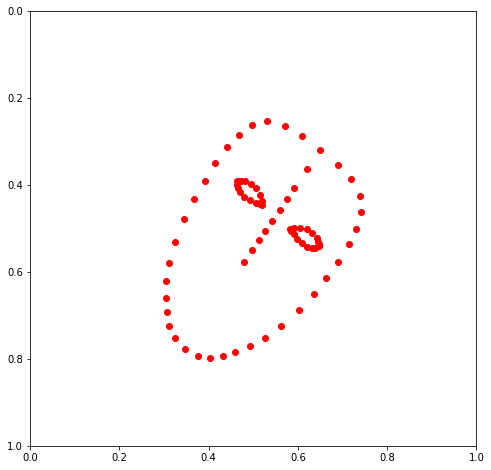

In [ ]:
j = 0
visualization_set = train_x[-6623:(len(train_x) - 1)]

i = 0
k = 0
x = []
y = []

while k < len(visualization_set[i]):
    x.append(visualization_set[i][k][0])
    y.append(visualization_set[i][k][1])
    k +=1

fig = plt.figure(figsize=(8,8))
ax = plt.axes(xlim=(0,1),ylim=(1,0))
scatter = ax.scatter(x, y, c='red')

def update(n):
    x = []
    y = []
    k = 0
    global i
    coords = []

    while k < len(visualization_set[i]):
        x.append(visualization_set[i][k][0])
        y.append(visualization_set[i][k][1])
        coords.append([visualization_set[i][k][0], visualization_set[i][k][1]])

        k +=1

    
    scatter.set_offsets(coords)
    i += 1
    return scatter

anim = FuncAnimation(fig, update, frames=(int(len(visualization_set)) - 1), interval=60)
HTML(anim.to_html5_video())

### Data Augmentation VAE Setup/Performance

In [ ]:
vae.compile(optimizer="adam", loss="mean_squared_error", metrics=["mean_squared_error"])

In [ ]:
vae.fit(x=train_x, y=train_x, epochs=50)

Epoch 1/50
7628/7628 [==============================] - 39s 5ms/step - loss: 0.0044 - mean_squared_error: 0.0023 - kl_loss: 0.0021
Epoch 2/50
7628/7628 [==============================] - 38s 5ms/step - loss: 0.0033 - mean_squared_error: 0.0013 - kl_loss: 0.0019
Epoch 3/50
7628/7628 [==============================] - 38s 5ms/step - loss: 0.0032 - mean_squared_error: 0.0013 - kl_loss: 0.0019
Epoch 4/50
7628/7628 [==============================] - 37s 5ms/step - loss: 0.0032 - mean_squared_error: 0.0013 - kl_loss: 0.0019
Epoch 5/50
7628/7628 [==============================] - 37s 5ms/step - loss: 0.0032 - mean_squared_error: 0.0012 - kl_loss: 0.0019
Epoch 6/50
7628/7628 [==============================] - 38s 5ms/step - loss: 0.0032 - mean_squared_error: 0.0012 - kl_loss: 0.0019
Epoch 7/50
7628/7628 [==============================] - 37s 5ms/step - loss: 0.0031 - mean_squared_error: 0.0012 - kl_loss: 0.0019
Epoch 8/50
7628/7628 [==============================] - 38s 5ms/step - loss: 0.0031

In [ ]:
validation_metrics.append(vae.evaluate(val_x, val_x))

RuntimeError: ignored

In [ ]:
j = 0
reconstructions_arr = []
while j < (len(val_x)):
    example = np.array(val_x[j])
    reconstructions = vae_fixed.predict(np.reshape(example, (1, -1, 3)))
    reconstructions_arr.append(reconstructions[0])
    j += 1

i = 0
k = 0
x = []
y = []

while k < len(val_x[i]):
    x.append(val_x[i][k][0])
    y.append(val_x[i][k][1])
    k +=1

fig = plt.figure(figsize=(8,8))
ax = plt.axes(xlim=(0,1),ylim=(1,0))
scatter = ax.scatter(x, y, c='red')
scatter2 = ax.scatter(x, y, c='blue')

def update(n):
    x = []
    y = []
    k = 0
    global i
    coords = []
    coords2 = []

    while k < len(val_x[i]):
        x.append(val_x[i][k][0])
        y.append(val_x[i][k][1])
        coords.append([reconstructions_arr[i][k][0], reconstructions_arr[i][k][1]])
        coords2.append([val_x[i][k][0], val_x[i][k][1]])

        k +=1

    
    scatter.set_offsets(coords)
    scatter2.set_offsets(coords2)
    i += 1
    return scatter, scatter2

anim = FuncAnimation(fig, update, frames=(int(len(val_x)) - 1), interval=60)
HTML(anim.to_html5_video())

### Model Performance Comparison


Latent Dim Changes Performance Comparison 

In [ ]:
validation_metrics = []
x = 16

while x >= 1:
    latent_dim = x 
    features = len(train_x[0])

    vae_encoder_inputs = tf.keras.Input(shape=(features,3), name="vae_encoder_input")
    vae_encoder_flatten = tf.keras.layers.Flatten(name="vae_flatten")(vae_encoder_inputs)
    vae_encoder_dense_1 = tf.keras.layers.Dense(units=200, activation="relu", name="vae_dense_1")(vae_encoder_flatten)
    vae_encoder_dense_2 = tf.keras.layers.Dense(units=100, activation="relu", name="vae_dense_2")(vae_encoder_dense_1)
    vae_encoder_dense_3 = tf.keras.layers.Dense(units=50, activation="relu", name="vae_dense_3")(vae_encoder_dense_2)
    z_mean = tf.keras.layers.Dense(units=latent_dim, name="z_mean")(vae_encoder_dense_3)
    z_log_var = tf.keras.layers.Dense(units=latent_dim, name="z_log_var")(vae_encoder_dense_3)
    vae_encoder = tf.keras.Model(inputs=vae_encoder_inputs, outputs=[z_mean, z_log_var])

    vae_encoder.summary()

    z = Sampling(name="vae_sampling")([z_mean, z_log_var])

    vae_decoder_dense_1 = tf.keras.layers.Dense(50, activation="relu", name="vae_decoder_dense_1")(z)
    vae_decoder_dense_2 = tf.keras.layers.Dense(100, activation="relu", name="vae_decoder_dense_2")(vae_decoder_dense_1)
    vae_decoder_dense_3 = tf.keras.layers.Dense(200, activation="relu", name="vae_decoder_dense_3")(vae_decoder_dense_2)
    vae_decoder_dense_4 = tf.keras.layers.Dense(features*3, activation=None, name="vae_decoder_dense_4")(vae_decoder_dense_3)
    vae_decoder_outputs = tf.keras.layers.Reshape((features,3), name="vae_decoder_reshape")(vae_decoder_dense_4)

    vae_decoder = tf.keras.Model(inputs=z, outputs=vae_decoder_outputs)

    vae_decoder.summary()

    vae = tf.keras.Model(inputs=vae_encoder_inputs, outputs=vae_decoder_outputs, name="VAE")

    vae.summary()

    vae.compile(optimizer="adam", loss="mean_squared_error", metrics=["mean_squared_error"])

    vae.fit(x=train_x, y=train_x, epochs=50)

    vae_encoder_fixed = tf.keras.Model(inputs=vae_encoder_inputs, outputs=z_mean)

    vae_fixed = tf.keras.Sequential([vae_encoder_fixed, vae_decoder])

    vae_fixed.summary()
    validation_metrics.append(vae.evaluate(val_x, val_x))

    x = x / 2


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 vae_encoder_input (InputLayer)  [(None, 77, 3)]     0           []                               
                                                                                                  
 vae_flatten (Flatten)          (None, 231)          0           ['vae_encoder_input[0][0]']      
                                                                                                  
 vae_dense_1 (Dense)            (None, 200)          46400       ['vae_flatten[0][0]']            
                                                                                                  
 vae_dense_2 (Dense)            (None, 100)          20100       ['vae_dense_1[0][0]']            
                                                                                              

In [ ]:
latent_dim = 16
features = len(train_x[0])

vae_encoder_inputs = tf.keras.Input(shape=(features,3), name="vae_encoder_input")
vae_encoder_flatten = tf.keras.layers.Flatten(name="vae_flatten")(vae_encoder_inputs)
vae_encoder_dense_1 = tf.keras.layers.Dense(units=200, activation="relu", name="vae_dense_1")(vae_encoder_flatten)
vae_encoder_dense_2 = tf.keras.layers.Dense(units=100, activation="relu", name="vae_dense_2")(vae_encoder_dense_1)
vae_encoder_dense_3 = tf.keras.layers.Dense(units=50, activation="relu", name="vae_dense_3")(vae_encoder_dense_2)
z_mean = tf.keras.layers.Dense(units=latent_dim, name="z_mean")(vae_encoder_dense_3)
z_log_var = tf.keras.layers.Dense(units=latent_dim, name="z_log_var")(vae_encoder_dense_3)
vae_encoder = tf.keras.Model(inputs=vae_encoder_inputs, outputs=[z_mean, z_log_var])

vae_encoder.summary()

z = Sampling(name="vae_sampling")([z_mean, z_log_var])

vae_decoder_dense_1 = tf.keras.layers.Dense(50, activation="relu", name="vae_decoder_dense_1")(z)
vae_decoder_dense_2 = tf.keras.layers.Dense(100, activation="relu", name="vae_decoder_dense_2")(vae_decoder_dense_1)
vae_decoder_dense_3 = tf.keras.layers.Dense(200, activation="relu", name="vae_decoder_dense_3")(vae_decoder_dense_2)
vae_decoder_dense_4 = tf.keras.layers.Dense(features*3, activation=None, name="vae_decoder_dense_4")(vae_decoder_dense_3)
vae_decoder_outputs = tf.keras.layers.Reshape((features,3), name="vae_decoder_reshape")(vae_decoder_dense_4)

vae_decoder = tf.keras.Model(inputs=z, outputs=vae_decoder_outputs)

vae_decoder.summary()

vae = tf.keras.Model(inputs=vae_encoder_inputs, outputs=vae_decoder_outputs, name="VAE")

vae.summary()

vae.compile(optimizer="adam", loss="mean_squared_error", metrics=["mean_squared_error"])

vae.fit(x=train_x, y=train_x, epochs=50)

vae_encoder_fixed = tf.keras.Model(inputs=vae_encoder_inputs, outputs=z_mean)

vae_fixed = tf.keras.Sequential([vae_encoder_fixed, vae_decoder])

vae_fixed.summary()
validation_metrics.append(vae.evaluate(val_x, val_x))

[[0.0014668027870357037, 0.0004601155233103782, 0.0010067069670185447], [0.0024004438892006874, 0.0008301179623231292, 0.0015703371027484536], [0.003756977152079344, 0.0013077611802145839, 0.002449211897328496], [0.007075747940689325, 0.0039960104040801525, 0.003079643938690424], [0.011346819810569286, 0.007977562956511974, 0.0033691052813082933]]


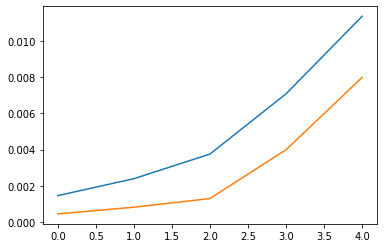

In [ ]:
print(validation_metrics)
loss = []
mse = []
for metric in validation_metrics:
    loss.append(metric[0])
    mse.append(metric[1])
plt.plot(loss)
plt.plot(mse)

### Augment Validation data

In [ ]:
length = len(val_x)
i = 0
while(i < length):
    val_x.append(rotate_around_point(val_x[i], 25, [0.5, 0.5]))
    i += 1
print(np.shape(val_x))

In [ ]:
len(val_x) / 2
len(val_x)
augmented_val_x = val_x[int(len(val_x) / 2):len(val_x)]
len(augmented_val_x)


### Export encoder

In [ ]:
from datetime import datetime
timestamp = datetime.now().strftime('%Y-%m-%d_%H:%M:%S')

vae_encoder_fixed.save('/content/drive/Shareddrives/URSI 2022/Eye Tracking ML/vae_encoder/vae_'+timestamp)

INFO:tensorflow:Assets written to: /content/drive/Shareddrives/URSI 2022/Eye Tracking ML/vae_encoder/vae_2022-07-21_17:15:34/assets


INFO:tensorflow:Assets written to: /content/drive/Shareddrives/URSI 2022/Eye Tracking ML/vae_encoder/vae_2022-07-21_17:15:34/assets
